In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/comp642-project
%mkdir -p v2
%cd v2

Mounted at /content/drive
/content/drive/MyDrive/comp642-project
/content/drive/MyDrive/comp642-project/v2


In [2]:
!nvidia-smi

Tue Apr 30 03:32:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   47C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import time

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Data Preprocessing

In [5]:
# Using small dataset for now
TRAIN_END_DATE = 424
TEST_END_DATE = 481
df = pd.read_csv('../data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [7]:
# Checking missing values
# Far price and near price have a lot of missing values, because this data is only available for last 5 minutes.
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

## Split into train and test data

In [6]:
train_df = df[df['date_id'] <= TRAIN_END_DATE]
test_df = df[(df['date_id'] > TRAIN_END_DATE) & (df['date_id'] <= TEST_END_DATE)]
# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)
train_df = train_df.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])
test_df = test_df.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])
del df

# Two-step Prediction (WAP -> Target)

### Set up for predicting wap_{t+60}

In [13]:
# may not be needed

# # Adding our target wap_{t+60} to train and test data
# train_df = train_df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"], ignore_index=True)
# train_df['wap_t+60'] = train_df.groupby('stock_id')['wap'].shift(-6)

# # The last 6 rows has NaN value for wap_{t+60}, so we will drop it
# def delete_last_6_rows(group):
#     return group.drop(group.tail(6).index)
# train_df = train_df.groupby('stock_id').apply(delete_last_6_rows).reset_index(drop=True)

# # Same for test data
# test_df = test_df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"], ignore_index=True)
# test_df['wap_t+60'] = test_df.groupby('stock_id')['wap'].shift(-6)
# test_df = test_df.groupby('stock_id').apply(delete_last_6_rows).reset_index(drop=True)

# train_df = train_df.dropna(subset=['target', 'wap_t+60'])
# test_df = test_df.dropna(subset=['target', 'wap_t+60'])

In [14]:
# Getting features and target columns
# featured_columns = ['date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
#                     'reference_price', 'matched_size',
#                     'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
#                     'ask_size', 'wap']
# target_column = 'wap_t+60'
# X_train = train_df[featured_columns]
# y_train = train_df[target_column]
# X_test = test_df[featured_columns]
# y_test = test_df[target_column]

In [7]:
train_df['wap_t+60'] = train_df.groupby(['stock_id', 'date_id'])['wap'].shift(-6)
test_df['wap_t+60'] = test_df.groupby(['stock_id', 'date_id'])['wap'].shift(-6)
train_df = train_df.dropna(subset=['wap_t+60'])
test_df = test_df.dropna(subset=['wap_t+60'])

## Baseline Model for WAP prediction

In [8]:
print("Baseline Model results")
baseline_pred = 0.999910 # mean of wap_t
train_baseline_mae = mean_absolute_error(train_df['wap_t+60'], [baseline_pred] * len(train_df['wap_t+60']))
train_baseline_mse = mean_squared_error(train_df['wap_t+60'], [baseline_pred] * len(train_df['wap_t+60']))
train_baseline_r2 = r2_score(train_df['wap_t+60'], [baseline_pred] * len(train_df['wap_t+60']))
test_baseline_mae = mean_absolute_error(test_df['wap_t+60'], [baseline_pred] * len(test_df['wap_t+60']))
test_baseline_mse = mean_squared_error(test_df['wap_t+60'], [baseline_pred] * len(test_df['wap_t+60']))
test_baseline_r2 = r2_score(test_df['wap_t+60'], [baseline_pred] * len(test_df['wap_t+60']))

print("Train MAE:", train_baseline_mae)
print("Train MSE:", train_baseline_mse)
print("Train R2:", train_baseline_r2)
print("Test MAE:", test_baseline_mae)
print("Test R2:", test_baseline_r2)

Baseline Model results
Train MAE: 0.0018815652271690164
Train MSE: 7.112412509684127e-06
Train R2: -0.0012473954970995127
Test MAE: 0.001516831369783381
Test R2: -1.2229479275926991e-05


## Random Forest Regressor

In [15]:
# train_df = train_df.dropna(subset=['wap_t+60'])
# test_df = test_df.dropna(subset=['wap_t+60'])
# train_df = train_df.fillna(0)
# test_df = test_df.fillna(0)

In [9]:
featured_columns = ['date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
                    'reference_price', 'matched_size',
                    'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
                    'ask_size', 'wap']
target_column = 'wap_t+60'
X_train = train_df[featured_columns]
y_train = train_df[target_column]
X_test = test_df[featured_columns]
y_test = test_df[target_column]

In [ ]:
# This takes about 2 hours
start_time = time.time()
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train Random Forest Regressor: {(end_time-start_time)/60} minutes')

In [ ]:
start_time = time.time()
y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by Random Forest Regressor: {(end_time-start_time)/60} minutes')

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 0.00022738427606324823
Train Mean Squared Error: 1.2057245911202418e-07
Train R2 Score: 0.9652567368081184
Test Mean Absolute Error: 0.001083217785601826
Test Mean Squared Error: 2.8356692128571456e-06
Test R2 Score: 0.7001323683961438


## XGBoost

In [10]:
start_time = time.time()
xgbRegressor = xgb.XGBRegressor()
xgbRegressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train XGBRegressor: {(end_time-start_time)/60} minutes')

# start_time = time.time()
# xgbRegressor = xgb.XGBRegressor(n_estimators=300, learning_rate=0.2)
# xgbRegressor.fit(X_train, y_train)
# end_time = time.time()
# print(f'Time taken to train XGBRegressor: {(end_time-start_time)/60} minutes')

Time taken to train XGBRegressor: 0.18210288683573406 minutes


In [11]:
start_time = time.time()
y_pred_train = xgbRegressor.predict(X_train)
y_pred_test = xgbRegressor.predict(X_test)
end_time = time.time()

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 0.0007305114503204474
Train Mean Squared Error: 1.1142427132844122e-06
Train R2 Score: 0.8431428698618626
Test Mean Absolute Error: 0.0006659902375616271
Test Mean Squared Error: 1.0960772592719647e-06
Test R2 Score: 0.7779910500499058


## Fine-tuning XGBoost

In [ ]:
# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)
# X_train_gpu = torch.tensor(X_train.values).to('cuda')
# y_train_gpu = torch.tensor(y_train.values).to('cuda')

In [18]:
param_space = {
    'learning_rate': [0.01, 0.1, 0.2, 1],
    # 'max_depth': [3, 5, 7, 10],
    # 'subsample': [0.4, 0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 200, 300]
}

torch.cuda.empty_cache()
xgb_gpu = xgb.XGBRegressor(device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_gpu, param_distributions=param_space,
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=3,
                                   verbose=1, n_jobs=-1, random_state=8)
# using data on gpu causes OutOfMemory: available 22.5 GB, needs 24 GB (in case of L4)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 300, 'learning_rate': 0.2}
Best Score: 0.000731211762775695


In [19]:
xgb_best_model = random_search.best_estimator_
y_pred_test = xgb_best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Test Mean Absolute Error: 0.0006576640109491797
Test Mean Squared Error: 1.0821658717537807e-06
Test R2 Score: 0.7591296919222936


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:52:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


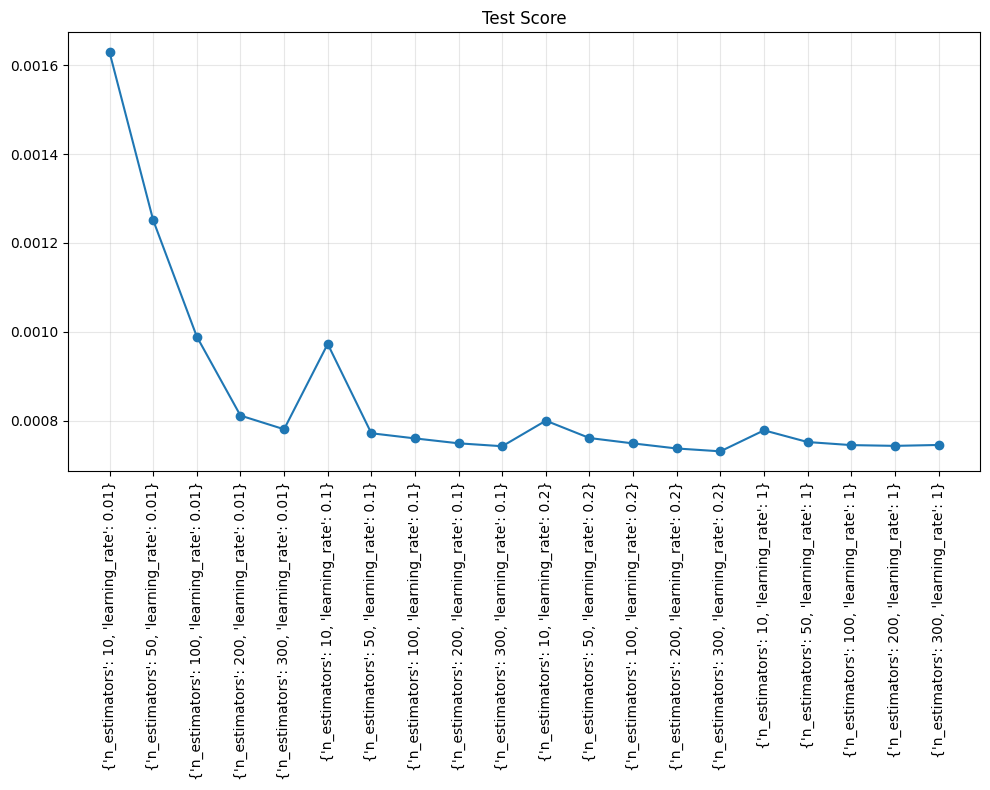

In [21]:
results = random_search.cv_results_
mean_scores = random_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 8))
plt.plot(range(len(mean_scores)), -mean_scores, marker='o', linestyle='-')
plt.title('Test Score')
params = [str(m) for m in random_search.cv_results_['params']]
plt.xticks(range(len(mean_scores)), params, rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Target Prediction

In [12]:
WEIGHTS = np.loadtxt('../index_return_coef.csv', delimiter=',')[:, 1]
intercept = WEIGHTS[-1]
WEIGHTS = WEIGHTS[:-1]

In [13]:
# train_df = train_df.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], ignore_index=True)
# test_df = test_df.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], ignore_index=True)
test_df['wap_t+60_pred'] = y_pred_test

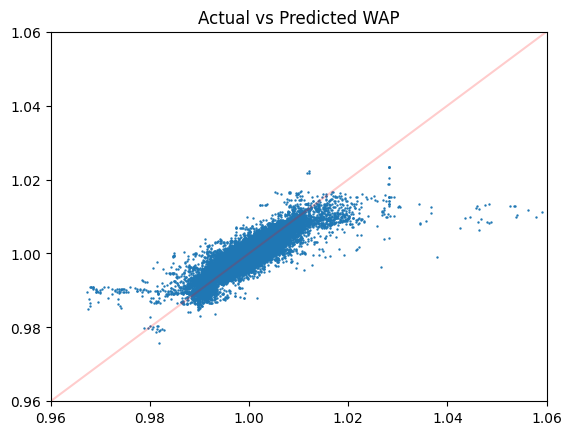

In [14]:
plt.scatter(test_df['wap_t+60'], test_df['wap_t+60_pred'], s=0.5)
plt.title('Actual vs Predicted WAP')
plt.xlim((0.96, 1.06))
plt.ylim((0.96, 1.06))
plt.axline([0, 0], [1, 1], alpha=0.2, color='red')
plt.show()

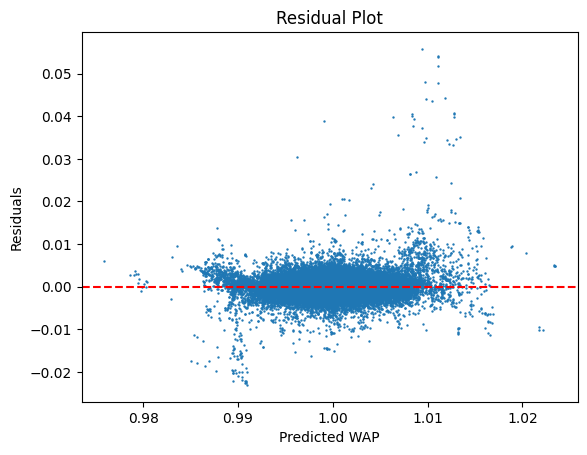

In [15]:
residuals = test_df['wap_t+60'] - test_df['wap_t+60_pred']
plt.scatter(test_df['wap_t+60_pred'], residuals, s=0.5)
plt.xlabel('Predicted WAP')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [16]:
def compute_index(df, wap_column='wap_t+60_pred', index_column='index_wap'):
    for _, records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        # records = records.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])
        curr_x = records[wap_column] / records['wap'] * 10000
        if curr_x.size != 200:
            continue
        index_wap = np.dot(WEIGHTS, curr_x) + intercept
        df.loc[records.index, index_column] = [index_wap] * records.index.size

    return df

test_df = compute_index(test_df, wap_column='wap_t+60_pred')
test_df = test_df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
test_df["predicted_target"] = test_df["wap_t+60_pred"] / test_df["wap"] * 10000 - test_df["index_wap"]
test_df = test_df[~test_df["predicted_target"].isna()]

mae_test = mean_absolute_error(test_df["target"], test_df["predicted_target"])
mse_test = mean_squared_error(test_df["target"], test_df["predicted_target"])
r2_score_test = r2_score(test_df["target"], test_df["predicted_target"])

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_score_test)

100%|██████████| 2744/2744 [00:01<00:00, 1448.67it/s]


Test Mean Absolute Error: 6.026710533572709
Test Mean Squared Error: 94.79566958272382
Test R2 Score: -0.20741752647373524


In [18]:
train_df['wap_t+60_pred'] = y_pred_train
train_df = compute_index(train_df, wap_column='wap_t+60_pred')
train_df = train_df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
train_df["predicted_target"] = train_df["wap_t+60_pred"] / train_df["wap"] * 10000 - train_df["index_wap"]
train_df = train_df[~train_df["predicted_target"].isna()]

mae_train = mean_absolute_error(train_df["target"], train_df["predicted_target"])
mse_train = mean_squared_error(train_df["target"], train_df["predicted_target"])
r2_score_train = r2_score(train_df["target"], train_df["predicted_target"])

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_score_train)

100%|██████████| 20825/20825 [00:09<00:00, 2167.40it/s]


Train Mean Absolute Error: 6.392536542711596
Train Mean Squared Error: 86.74201771033007
Train R2 Score: 0.05298427114855053


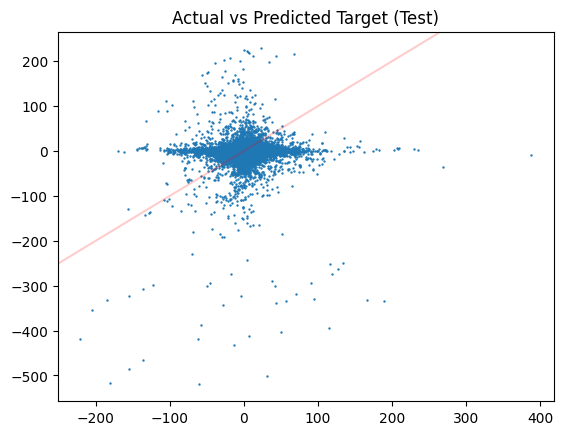

In [19]:
plt.scatter(test_df['target'], test_df['predicted_target'], s=0.5)
plt.title('Actual vs Predicted Target (Test)')
# plt.xlim((0.96, 1.06))
# plt.ylim((0.96, 1.06))
plt.axline([0, 0], [1, 1], alpha=0.2, color='red')
plt.show()

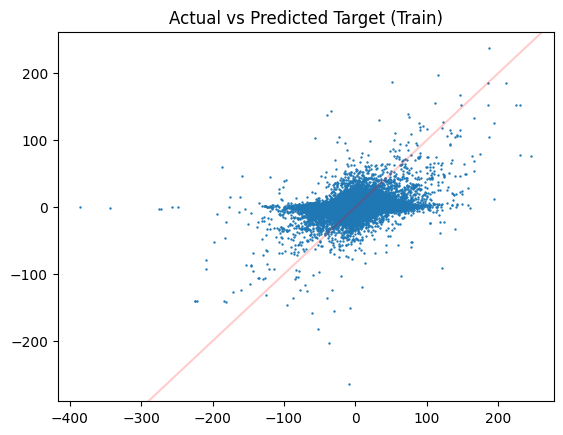

In [20]:
plt.scatter(train_df['target'], train_df['predicted_target'], s=0.5)
plt.title('Actual vs Predicted Target (Train)')
# plt.xlim((0.96, 1.06))
# plt.ylim((0.96, 1.06))
plt.axline([0, 0], [1, 1], alpha=0.2, color='red')
plt.show()

## Stacking

### CatBoost

In [33]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.4 MB/s eta 0:00:00


In [37]:
X_train.columns
# featured_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
#                     'reference_price', 'matched_size',
#                     'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
#                     'ask_size', 'wap']
# target_column = 'wap_t+60'
# X_train = train_df[featured_columns]
# y_train = train_df[target_column]
# X_test = test_df[featured_columns]
# y_test = test_df[target_column]

Index(['date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap'],
      dtype='object')

In [38]:
from catboost import CatBoostRegressor

cat_features=[3] # imbalance_buy_sell_flag

start_time = time.time()
catboost_regressor = CatBoostRegressor(cat_features=cat_features, iterations=300, learning_rate=0.2)
catboost_regressor.fit(X_train, y_train, verbose=0)
end_time = time.time()

print(f'Time taken to train CatBoostRegressor: {(end_time - start_time) / 60} minutes')

Time taken to train CatBoostRegressor: 1.7370362679163616 minutes


In [39]:
catboost_y_pred_train = catboost_regressor.predict(X_train)
catboost_y_pred_test = catboost_regressor.predict(X_test)

mae_train = mean_absolute_error(y_train, catboost_y_pred_train)
mse_train = mean_squared_error(y_train, catboost_y_pred_train)
r2_train = r2_score(y_train, catboost_y_pred_train)
mae_test = mean_absolute_error(y_test, catboost_y_pred_test)
mse_test = mean_squared_error(y_test, catboost_y_pred_test)
r2_test = r2_score(y_test, catboost_y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 0.0007629117060298342
Train Mean Squared Error: 1.2373682716035959e-06
Train R2 Score: 0.8258099122446892
Test Mean Absolute Error: 0.0006608253173993682
Test Mean Squared Error: 1.065859813743158e-06
Test R2 Score: 0.7841115523185875


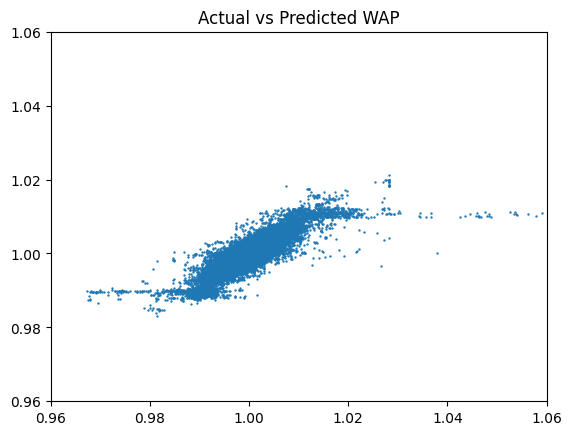

In [43]:
plt.scatter(y_test, catboost_y_pred_test, s=0.5)
plt.title('Actual vs Predicted WAP')
plt.xlim((0.96, 1.06))
plt.ylim((0.96, 1.06))
plt.show()

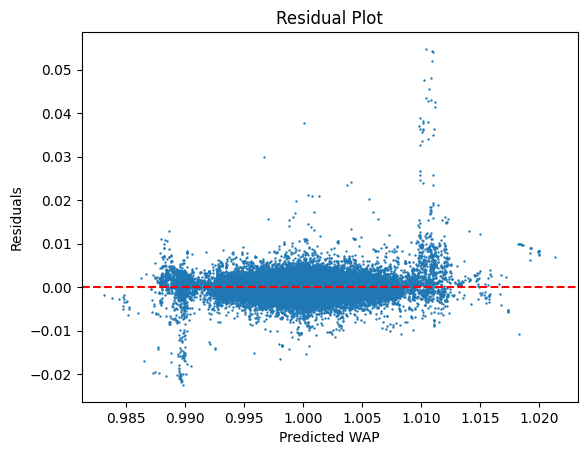

In [44]:
residuals = y_test - catboost_y_pred_test
plt.scatter(catboost_y_pred_test, residuals, s=0.5)
plt.xlabel('Predicted WAP')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### XGBoost

In [45]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()
xgbRegressor = xgb.XGBRegressor(n_estimators=300, learning_rate=0.2)
xgbRegressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train XGBRegressor: {(end_time-start_time)/60} minutes')

Time taken to train XGBRegressor: 0.5412073493003845 minutes


In [46]:
xgboost_y_pred_train = xgbRegressor.predict(X_train)
xgboost_y_pred_test = xgbRegressor.predict(X_test)

mae_train = mean_absolute_error(y_train, xgboost_y_pred_train)
mse_train = mean_squared_error(y_train, xgboost_y_pred_train)
r2_train = r2_score(y_train, xgboost_y_pred_train)
mae_test = mean_absolute_error(y_test, xgboost_y_pred_test)
mse_test = mean_squared_error(y_test, xgboost_y_pred_test)
r2_test = r2_score(y_test, xgboost_y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 0.0007132568336088472
Train Mean Squared Error: 1.0511553498369705e-06
Train R2 Score: 0.852023971492923
Test Mean Absolute Error: 0.0006717123460219732
Test Mean Squared Error: 1.106850885657855e-06
Test R2 Score: 0.7758088667586706


### Stack

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

base_models = [
    ('catboost', catboost_regressor),
    ('xgboost', xgbRegressor)
]

start_time = time.time()
meta_model = LinearRegression()
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, verbose=0)
stacking_regressor.fit(X_train, y_train)
end_time = time.time()

In [50]:
print(f'Time taken to train StackingRegressor: {(end_time-start_time)/60} minutes')
stack_y_pred = stacking_regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, stack_y_pred)
mse_test = mean_squared_error(y_test, stack_y_pred)
r2_test = r2_score(y_test, stack_y_pred)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Time taken to train StackingRegressor: 10.20877114534378 minutes
Test Mean Absolute Error: 0.0006753584394256862
Test Mean Squared Error: 1.1181629940969533e-06
Test R2 Score: 0.7735176146639471


## Lagged Features

In [51]:
def add_features(df, n_lag=5):
  for i in range(1, n_lag):
    df[f'imbalance_size_lag_{i}'] = df.groupby('stock_id')['imbalance_size'].shift(i)
    df[f'reference_price_lag_{i}'] = df.groupby('stock_id')['reference_price'].shift(i)
    df[f'matched_size_lag_{i}'] = df.groupby('stock_id')['matched_size'].shift(i)
    df[f'bid_price_lag_{i}'] = df.groupby('stock_id')['bid_price'].shift(i)
    df[f'ask_price_lag_{i}'] = df.groupby('stock_id')['ask_price'].shift(i)
    df[f'wap_{i}'] = df.groupby('stock_id')['wap'].shift(i)

  df['bid_size_lag_1'] = df.groupby('stock_id')['bid_size'].shift(1)
  df['ask_size_lag_1'] = df.groupby('stock_id')['ask_size'].shift(1)

  return df

train_df = add_features(train_df)
test_df = add_features(test_df)

### CatBoost

In [52]:
featured_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap',
       'imbalance_size_lag_1', 'reference_price_lag_1', 'matched_size_lag_1',
       'bid_price_lag_1', 'ask_price_lag_1', 'wap_1', 'imbalance_size_lag_2',
       'reference_price_lag_2', 'matched_size_lag_2', 'bid_price_lag_2',
       'ask_price_lag_2', 'wap_2', 'imbalance_size_lag_3',
       'reference_price_lag_3', 'matched_size_lag_3', 'bid_price_lag_3',
       'ask_price_lag_3', 'wap_3', 'imbalance_size_lag_4',
       'reference_price_lag_4', 'matched_size_lag_4', 'bid_price_lag_4',
       'ask_price_lag_4', 'wap_4', 'bid_size_lag_1', 'ask_size_lag_1']
X_train_cat = train_df[featured_columns]
X_test_cat = test_df[featured_columns]

In [56]:
X_train_cat.columns.get_loc('imbalance_buy_sell_flag')

4

In [57]:
cat_features=[0, 4] # stock_id, imbalance_buy_sell_flag

start_time = time.time()
catboost_regressor = CatBoostRegressor(cat_features=cat_features, iterations=300, learning_rate=0.1)
catboost_regressor.fit(X_train_cat, y_train, verbose=0)
end_time = time.time()

print(f'Time taken to train CatBoostRegressor: {(end_time - start_time) / 60} minutes')

Time taken to train CatBoostRegressor: 2.3142433007558187 minutes


In [59]:
catboost_y_pred_train = catboost_regressor.predict(X_train_cat)
catboost_y_pred_test = catboost_regressor.predict(X_test_cat)

mae_train = mean_absolute_error(y_train, catboost_y_pred_train)
mse_train = mean_squared_error(y_train, catboost_y_pred_train)
r2_train = r2_score(y_train, catboost_y_pred_train)
mae_test = mean_absolute_error(y_test, catboost_y_pred_test)
mse_test = mean_squared_error(y_test, catboost_y_pred_test)
r2_test = r2_score(y_test, catboost_y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 0.0007623683929803185
Train Mean Squared Error: 1.2281469070964037e-06
Train R2 Score: 0.8271080466235915
Test Mean Absolute Error: 0.0006608349423534664
Test Mean Squared Error: 1.0565690144505614e-06
Test R2 Score: 0.78419757946897


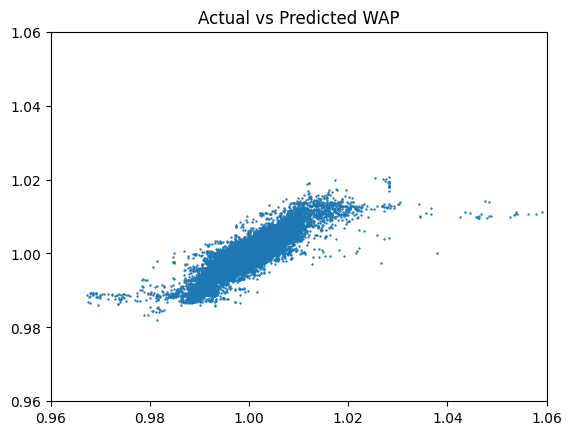

In [60]:
plt.scatter(y_test, catboost_y_pred_test, s=0.5)
plt.title('Actual vs Predicted WAP')
plt.xlim((0.96, 1.06))
plt.ylim((0.96, 1.06))
plt.show()

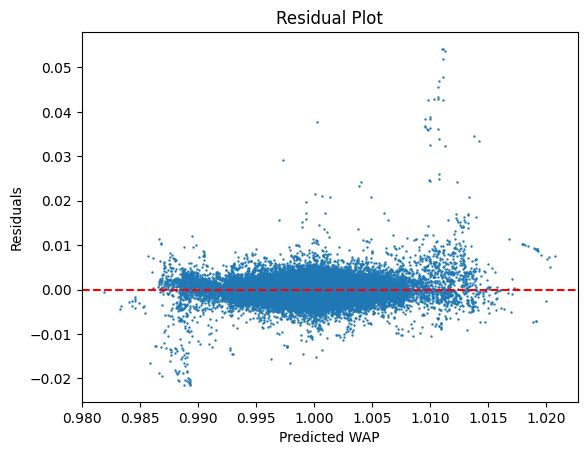

In [61]:
residuals = y_test - catboost_y_pred_test
plt.scatter(catboost_y_pred_test, residuals, s=0.5)
plt.xlabel('Predicted WAP')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Almost no difference to previous results.

In [62]:
test_df['wap_t+60_pred'] = catboost_y_pred_test

In [64]:
def compute_index(df, wap_column='wap_t+60_pred', index_column='index_wap'):
    for _, records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        curr_x = records[wap_column] / records['wap'] * 10000
        if curr_x.size != 200:
            continue
        index_wap = np.dot(WEIGHTS, curr_x) + intercept
        df.loc[records.index, index_column] = [index_wap] * records.index.size

    return df

test_df = compute_index(test_df, wap_column='wap_t+60_pred')
test_df["predicted_target"] = test_df["wap_t+60_pred"] / test_df["wap"] * 10000 - test_df["index_wap"]
test_df = test_df.dropna(subset=['predicted_target', 'target'])

mae_test = mean_absolute_error(test_df["target"], test_df["predicted_target"])
mse_test = mean_squared_error(test_df["target"], test_df["predicted_target"])
r2_score_test = r2_score(test_df["target"], test_df["predicted_target"])

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_score_test)

100%|██████████| 2695/2695 [00:02<00:00, 1161.75it/s]


Test Mean Absolute Error: 5.978514940569619
Test Mean Squared Error: 90.8777743075551
Test R2 Score: -0.15751508427410266


## What if we use true wap_t+60?

In [65]:
test_df = compute_index(test_df, wap_column='wap_t+60')
test_df["predicted_target"] = test_df["wap_t+60"] / test_df["wap"] * 10000 - test_df["index_wap"]
test_df = test_df.dropna(subset=['predicted_target', 'target'])

mae_test = mean_absolute_error(test_df["target"], test_df["predicted_target"])
mse_test = mean_squared_error(test_df["target"], test_df["predicted_target"])
r2_score_test = r2_score(test_df["target"], test_df["predicted_target"])

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_score_test)

100%|██████████| 2695/2695 [00:02<00:00, 1299.95it/s]


Test Mean Absolute Error: 0.004049204498093278
Test Mean Squared Error: 2.490145601655334e-05
Test R2 Score: 0.9999996828288195


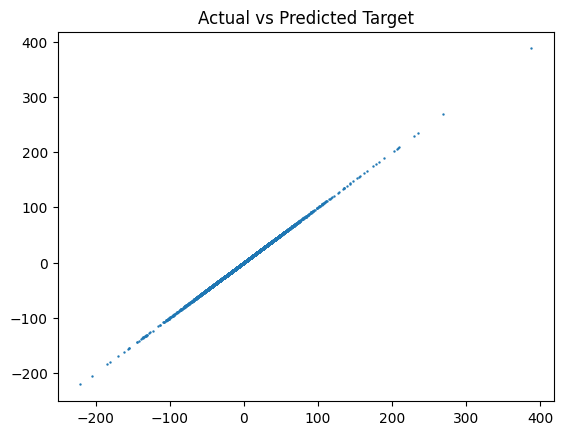

In [67]:
plt.scatter(test_df["target"], test_df["predicted_target"], s=0.5)
plt.title('Actual vs Predicted Target')
plt.show()

# Direct Prediction

In [34]:
X_train.columns

Index(['date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap'],
      dtype='object')

In [72]:
target_column = 'target'
y_train = train_df[target_column]
y_test = test_df[target_column]

In [80]:
X_test.shape

(548751, 13)

## cuML Random Forest

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

If using stock_id, needs one-hot encoding.

In [39]:
import cuml
from cuml.ensemble import RandomForestRegressor

start_time = time.time()
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train Random Forest Regressor: {(end_time-start_time)/60} minutes')

Time taken to train Random Forest Regressor: 3.9534623861312865 minutes


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [40]:
y_pred = rf_regressor.predict(X_test)
test_score = rf_regressor.score(X_test, y_test)
print("Test R^2 Score:", test_score)
print("Test MSE score:", mean_squared_error(y_pred, y_test))
print("Test MAE score:", mean_absolute_error(y_pred, y_test))

Test R^2 Score: 0.0025227893898660536
Test MSE score: 75.95847039831699
Test MAE score: 5.824107015073951


## XGBoost

In [9]:
# train_df = train_df.dropna(subset=['target'])
# test_df = test_df.dropna(subset=['target'])

In [35]:
featured_columns = ['date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
                    'reference_price', 'matched_size',
                    'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
                    'ask_size', 'wap']
target_column = 'target'
X_train = train_df[featured_columns]
y_train = train_df[target_column]
X_test = test_df[featured_columns]
y_test = test_df[target_column]

In [36]:
start_time = time.time()
xgbRegressor = xgb.XGBRegressor(n_estimators=300, learning_rate=0.2)
xgbRegressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train XGBRegressor: {(end_time-start_time)/60} minutes')

Time taken to train XGBRegressor: 0.1041940967241923 minutes


In [37]:
start_time = time.time()
y_pred_train = xgbRegressor.predict(X_train)
y_pred_test = xgbRegressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by XGBoost: {(end_time-start_time)/60} minutes')

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Inference time taken by XGBoost: 0.024191860357920328 minutes
Train Mean Absolute Error: 6.076834841640662
Train Mean Squared Error: 75.21034908850562
Train R2 Score: 0.1612933789802452
Test Mean Absolute Error: 5.94309369997662
Test Mean Squared Error: 79.79783179656296
Test R2 Score: -0.04822097538262082


## Tuning XGBoost

In [ ]:
import torch

param_space = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 10, None],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.1, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

torch.cuda.empty_cache()

start_time = time.time()
xgb_gpu = xgb.XGBRegressor(device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_gpu, param_distributions=param_space,
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=3,
                                   verbose=1, n_jobs=-1, random_state=8)
# using data on gpu causes OutOfMemory: available 22.5 GB, needs 24 GB
random_search.fit(X_train, y_train)

end_time = time.time()
print(f'Time taken to fine-tine XGBRegressor: {(end_time-start_time)/60} minutes')

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Time taken to fine-tine XGBRegressor: 6.464599863688151 minutes
Best Parameters: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Score: 6.393966304041025


In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_test = xgb_best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Test Mean Absolute Error: 5.79754806602575
Test Mean Squared Error: 75.126807112687
Test R2 Score: 0.013445689988534237


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:23:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


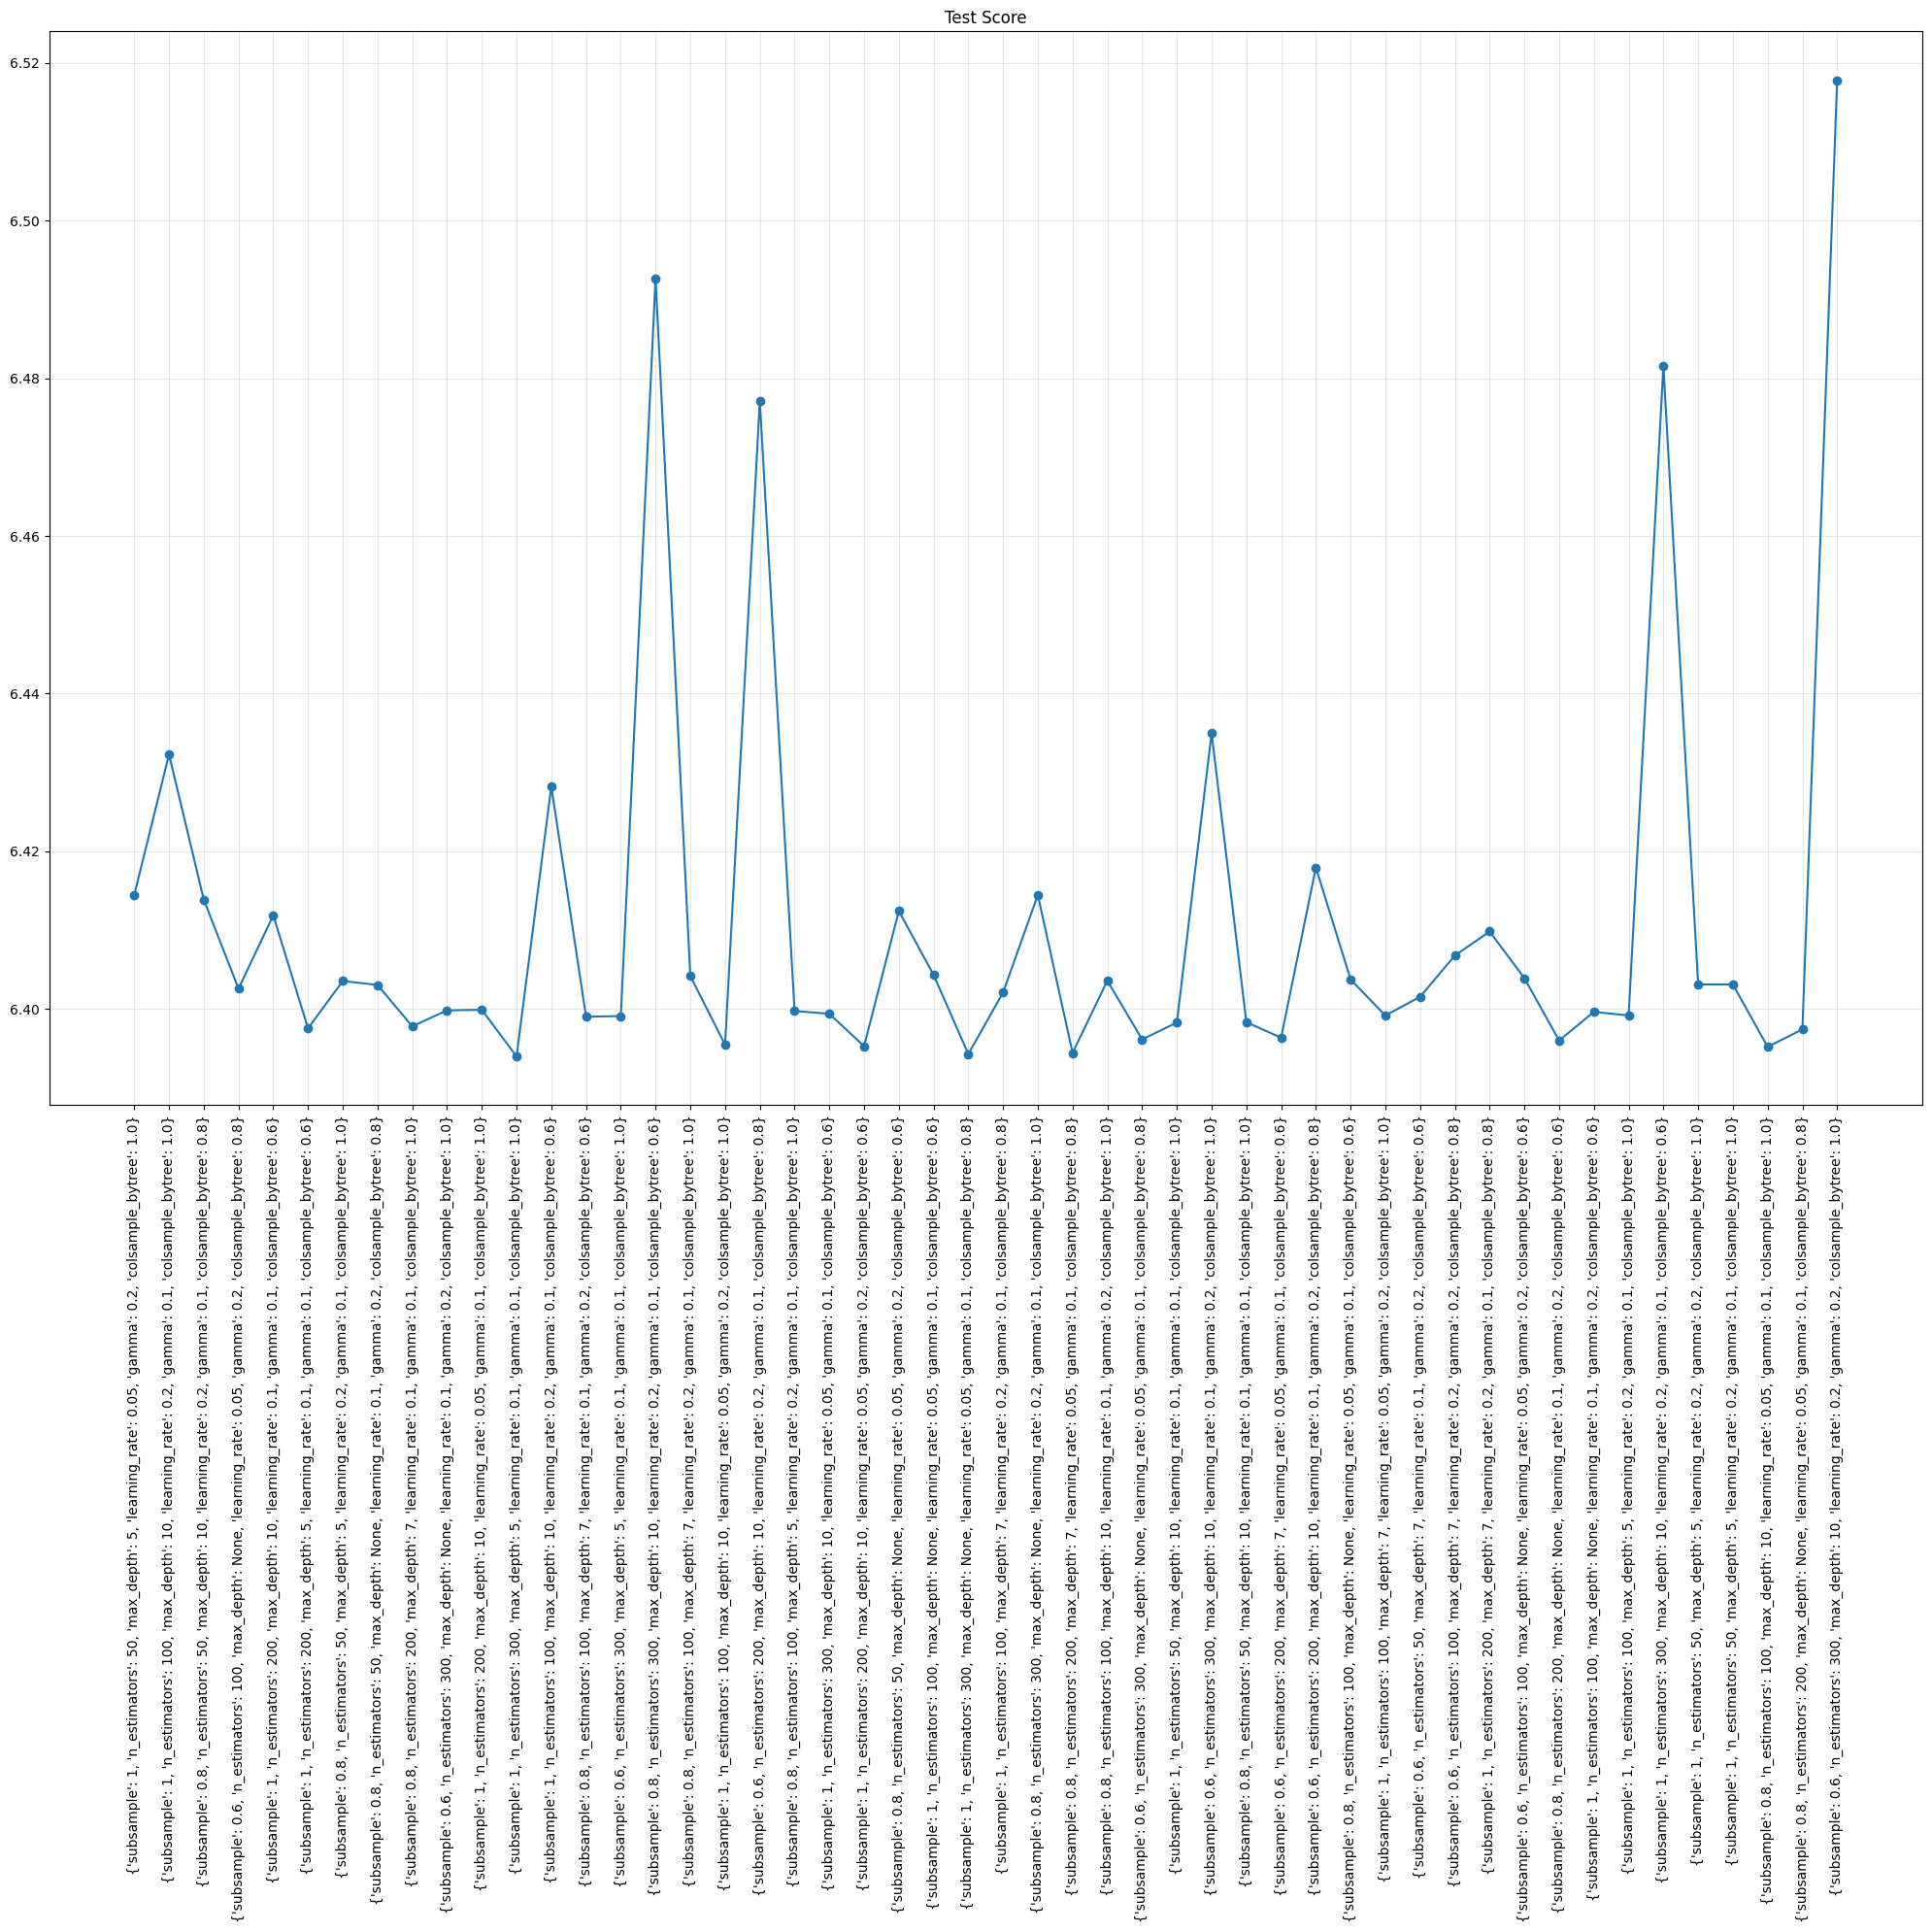

In [ ]:
results = random_search.cv_results_
mean_scores = random_search.cv_results_['mean_test_score']
plt.figure(figsize=(20, 20))
plt.plot(range(len(mean_scores)), -mean_scores, marker='o', linestyle='-')
plt.title('Test Score')
params = [str(m) for m in random_search.cv_results_['params']]
plt.xticks(range(len(mean_scores)), params, rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_train = xgb_best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)

Train Mean Absolute Error: 6.353938067824539
Train Mean Squared Error: 86.47786666118944
Train R2 Score: 0.05090977885793935


## Lagged features

In [18]:
def add_features(df, n_lag=5):
  for i in range(1, n_lag):
    df[f'imbalance_size_lag_{i}'] = df.groupby('stock_id')['imbalance_size'].shift(i)
    df[f'reference_price_lag_{i}'] = df.groupby('stock_id')['reference_price'].shift(i)
    df[f'matched_size_lag_{i}'] = df.groupby('stock_id')['matched_size'].shift(i)
    df[f'bid_price_lag_{i}'] = df.groupby('stock_id')['bid_price'].shift(i)
    df[f'ask_price_lag_{i}'] = df.groupby('stock_id')['ask_price'].shift(i)
    df[f'wap_{i}'] = df.groupby('stock_id')['wap'].shift(i)

  df['bid_size_lag_1'] = df.groupby('stock_id')['bid_size'].shift(1)
  df['ask_size_lag_1'] = df.groupby('stock_id')['ask_size'].shift(1)

  return df

train_df = add_features(train_df)
test_df = add_features(test_df)

In [84]:
train_df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'wap_t+60',
       'imbalance_size_lag_1', 'reference_price_lag_1', 'matched_size_lag_1',
       'bid_price_lag_1', 'ask_price_lag_1', 'wap_1', 'imbalance_size_lag_2',
       'reference_price_lag_2', 'matched_size_lag_2', 'bid_price_lag_2',
       'ask_price_lag_2', 'wap_2', 'imbalance_size_lag_3',
       'reference_price_lag_3', 'matched_size_lag_3', 'bid_price_lag_3',
       'ask_price_lag_3', 'wap_3', 'imbalance_size_lag_4',
       'reference_price_lag_4', 'matched_size_lag_4', 'bid_price_lag_4',
       'ask_price_lag_4', 'wap_4', 'bid_size_lag_1', 'ask_size_lag_1'],
      dtype='object')

In [100]:
featured_columns = ['date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap',
       'imbalance_size_lag_1', 'reference_price_lag_1', 'matched_size_lag_1',
       'bid_price_lag_1', 'ask_price_lag_1', 'wap_1', 'imbalance_size_lag_2',
       'reference_price_lag_2', 'matched_size_lag_2', 'bid_price_lag_2',
       'ask_price_lag_2', 'wap_2', 'imbalance_size_lag_3',
       'reference_price_lag_3', 'matched_size_lag_3', 'bid_price_lag_3',
       'ask_price_lag_3', 'wap_3', 'imbalance_size_lag_4',
       'reference_price_lag_4', 'matched_size_lag_4', 'bid_price_lag_4',
       'ask_price_lag_4', 'wap_4', 'bid_size_lag_1', 'ask_size_lag_1']
target_column = 'target'
X_train = train_df[featured_columns]
y_train = train_df[target_column]
X_test = test_df[featured_columns]
y_test = test_df[target_column]

In [156]:
# Best Parameters: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

start_time = time.time()
xgbRegressor = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, gamma=0.1)
xgbRegressor.fit(X_train, y_train)
end_time = time.time()
print(f'Training time taken by XGBoost: {(end_time-start_time)/60} minutes')

Training time taken by XGBoost: 0.7439148227373759 minutes


In [157]:
start_time = time.time()
xgb_y_pred_train = xgbRegressor.predict(X_train)
xgb_y_pred_test = xgbRegressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by XGBoost: {(end_time-start_time)/60} minutes')

xgb_mae_train = mean_absolute_error(y_train, xgb_y_pred_train)
xgb_mse_train = mean_squared_error(y_train, xgb_y_pred_train)
xgb_r2_train = r2_score(y_train, xgb_y_pred_train)
xgb_mae_test = mean_absolute_error(y_test, xgb_y_pred_test)
xgb_mse_test = mean_squared_error(y_test, xgb_y_pred_test)
xgb_r2_test = r2_score(y_test, xgb_y_pred_test)

print("Train Mean Absolute Error:", xgb_mae_train)
print("Train Mean Squared Error:", xgb_mse_train)
print("Train R2 Score:", xgb_r2_train)
print("Test Mean Absolute Error:", xgb_mae_test)
print("Test Mean Squared Error:", xgb_mse_test)
print("Test R2 Score:", xgb_r2_test)

Inference time taken by XGBoost: 0.07322463989257813 minutes
Train Mean Absolute Error: 6.3608957972374505
Train Mean Squared Error: 85.35451644764278
Train R2 Score: 0.07826103527056771
Test Mean Absolute Error: 5.895260240433749
Test Mean Squared Error: 77.47286824444951
Test R2 Score: 0.013223923030482587


In [ ]:
import torch
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_space = {
    'learning_rate': [0.1, 0.2, 1, 10],
    'max_depth': [5, 7],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

torch.cuda.empty_cache()

start_time = time.time()
xgb_gpu = xgb.XGBRegressor(device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_gpu, param_distributions=param_space,
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=3,
                                   verbose=1, n_jobs=-1, random_state=8)
# may cause OutOfMemory
random_search.fit(X_train, y_train)

end_time = time.time()
print(f'Time taken to fine-tine XGBRegressor: {(end_time-start_time)/60} minutes')

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken to fine-tine XGBRegressor: 12.298071642716726 minutes
Best Parameters: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best Score: 6.393380178835433


In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_test = xgb_best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:20:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Test Mean Absolute Error: 5.795017667437385
Test Mean Squared Error: 74.89253184130173
Test R2 Score: 0.01652215879636698


## CatBoost

In [22]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.0 MB/s eta 0:00:00


In [146]:
# X_train['date_id'] = train_df['date_id']
# X_train['seconds_in_bucket'] = train_df['seconds_in_bucket']
# X_test['date_id'] = test_df['date_id']
# X_test['seconds_in_bucket'] = test_df['seconds_in_bucket']
# X_train['stock_id'] = train_df['stock_id']
# X_test['stock_id'] = test_df['stock_id']
X_test_cat.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'imbalance_size_lag_1', 'reference_price_lag_1',
       'matched_size_lag_1', 'bid_price_lag_1', 'ask_price_lag_1', 'wap_1',
       'imbalance_size_lag_2', 'reference_price_lag_2', 'matched_size_lag_2',
       'bid_price_lag_2', 'ask_price_lag_2', 'wap_2', 'imbalance_size_lag_3',
       'reference_price_lag_3', 'matched_size_lag_3', 'bid_price_lag_3',
       'ask_price_lag_3', 'wap_3', 'imbalance_size_lag_4',
       'reference_price_lag_4', 'matched_size_lag_4', 'bid_price_lag_4',
       'ask_price_lag_4', 'wap_4', 'bid_size_lag_1', 'ask_size_lag_1'],
      dtype='object')

In [147]:
from catboost import CatBoostRegressor

# cat_features=[3] # imbalance_buy_sell_flag: : use X_train for Stacking
cat_features=[0, 4] # stock_id, imbalance_buy_sell_flag: use X_train_cat

start_time = time.time()
catboost_regressor = CatBoostRegressor(cat_features=cat_features, iterations=300, learning_rate=0.1)
catboost_regressor.fit(X_train_cat, y_train, verbose=0)
end_time = time.time()

print(f'Time taken to train CatBoostRegressor: {(end_time - start_time) / 60} minutes')

Time taken to train CatBoostRegressor: 2.4657957712809244 minutes


In [148]:
cat_y_pred_train = catboost_regressor.predict(X_train_cat)
cat_y_pred_test = catboost_regressor.predict(X_test_cat)

cat_mae_train = mean_absolute_error(y_train, y_pred_train)
cat_mse_train = mean_squared_error(y_train, y_pred_train)
cat_r2_train = r2_score(y_train, y_pred_train)
cat_mae_test = mean_absolute_error(y_test, y_pred_test)
cat_mse_test = mean_squared_error(y_test, y_pred_test)
cat_r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", cat_mae_train)
print("Train Mean Squared Error:", cat_mse_train)
print("Train R2 Score:", cat_r2_train)
print("Test Mean Absolute Error:", cat_mae_test)
print("Test Mean Squared Error:", cat_mse_test)
print("Test R2 Score:", cat_r2_test)

Train Mean Absolute Error: 6.417704026594188
Train Mean Squared Error: 88.41925430257906
Train R2 Score: 0.045165091257940326
Test Mean Absolute Error: 5.889195632198962
Test Mean Squared Error: 77.24134099683256
Test R2 Score: 0.016172897998004365


### Feature Importance

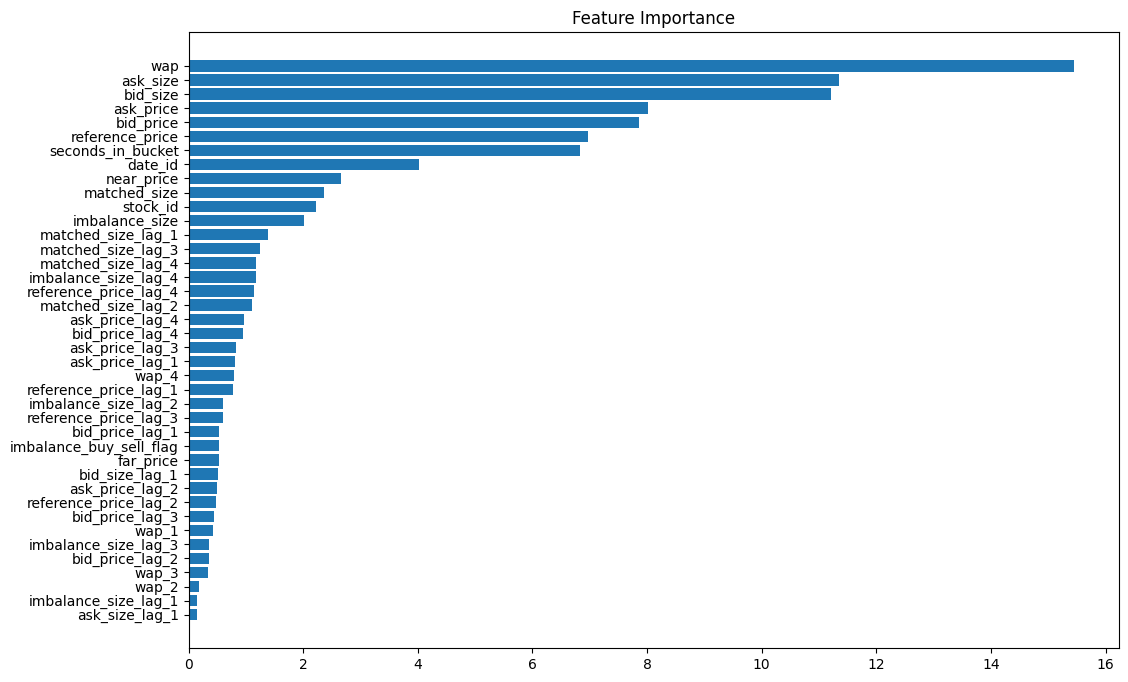

In [150]:
feature_importance = catboost_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_cat.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

## Stacking

In [130]:
y_train.shape, X_train_cat.shape, X_train.shape

((4117617,), (4117617, 40), (4117617, 39))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

base_models = [
    ('catboost', catboost_regressor),
    ('xgboost', xgbRegressor)
]

start_time = time.time()
meta_model = LinearRegression()
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, verbose=0)
# models must have the same features
stacking_regressor.fit(X_train, y_train)
end_time = time.time()

In [132]:
print(f'Time taken to train StackingRegressor: {(end_time-start_time)/60} minutes')
stack_y_pred = stacking_regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, stack_y_pred)
mse_test = mean_squared_error(y_test, stack_y_pred)
r2_test = r2_score(y_test, stack_y_pred)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Time taken to train StackingRegressor: 13.255115473270417 minutes
Test Mean Absolute Error: 5.8843163026543825
Test Mean Squared Error: 77.10931370358125
Test R2 Score: 0.017854536711526148


## Results

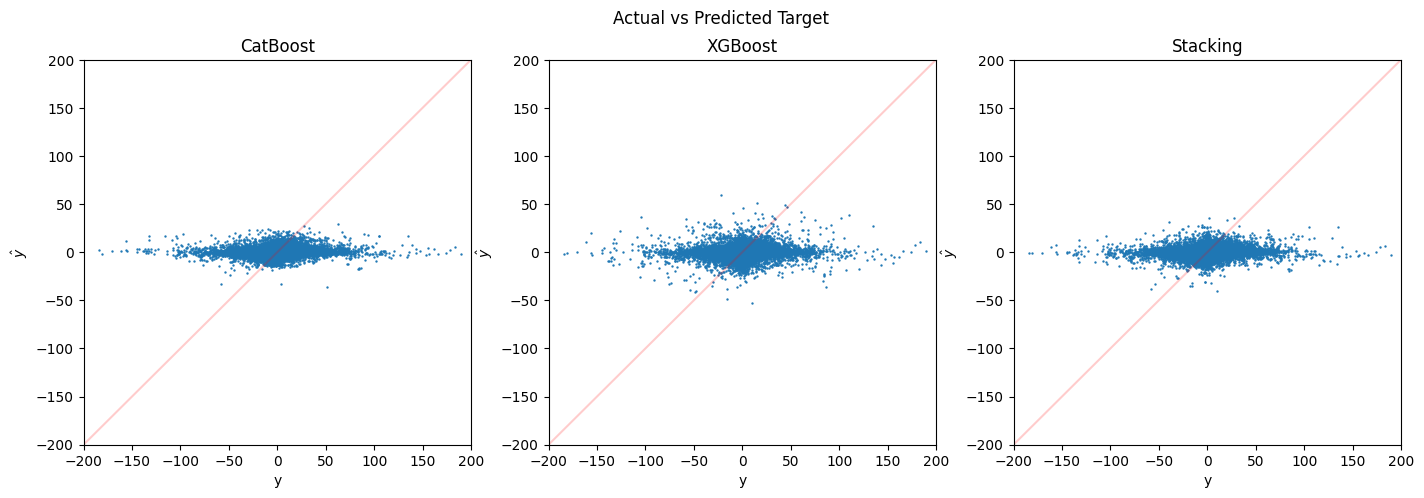

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))  # 1 row, 3 columns

axes[0].scatter(y_test, cat_y_pred_test, s=0.5)
axes[0].set_xlabel('y')
axes[0].set_ylabel('$\hat{y}$')
axes[0].set_xlim((-200, 200))
axes[0].set_ylim((-200, 200))
axes[0].axline([0, 0], [1, 1], c='red', alpha=0.2)
axes[0].set_title('CatBoost')

axes[1].scatter(y_test, xgb_y_pred_test, s=0.5)
axes[1].set_xlabel('y')
axes[1].set_ylabel('$\hat{y}$')
axes[1].set_xlim((-200, 200))
axes[1].set_ylim((-200, 200))
axes[1].axline([0, 0], [1, 1], c='red', alpha=0.2)
axes[1].set_title('XGBoost')

axes[2].scatter(y_test, stack_y_pred, s=0.5)
axes[2].set_xlabel('y')
axes[2].set_ylabel('$\hat{y}$')
axes[2].set_xlim((-200, 200))
axes[2].set_ylim((-200, 200))
axes[2].axline([0, 0], [1, 1], c='red', alpha=0.2)
axes[2].set_title('Stacking')

plt.suptitle('Actual vs Predicted Target')
plt.show()

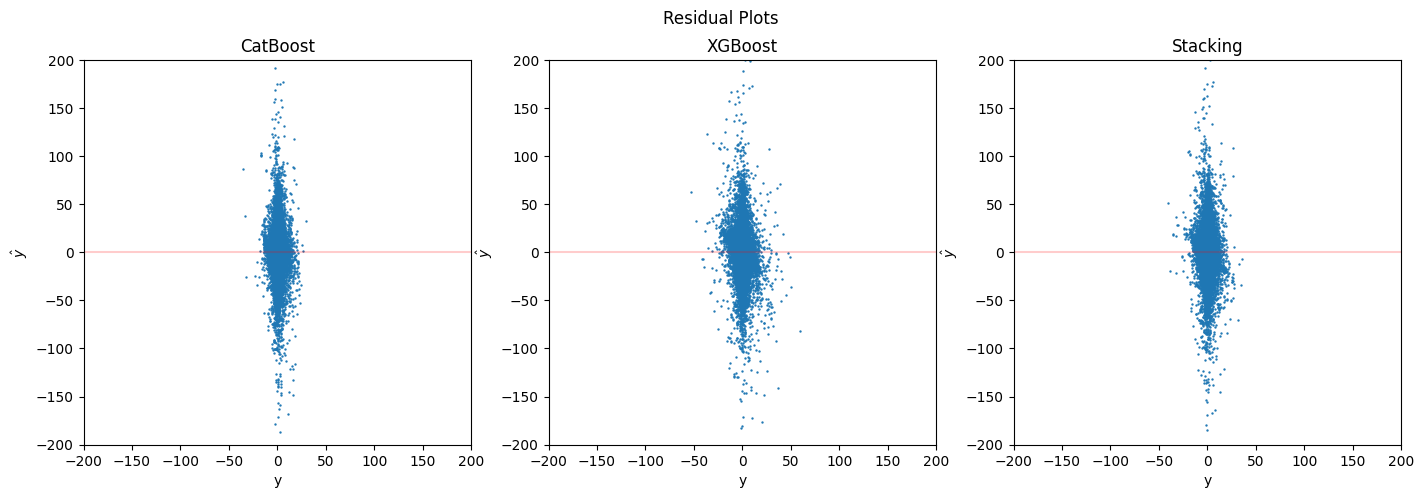

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))  # 1 row, 3 columns

axes[0].scatter(cat_y_pred_test, y_test - cat_y_pred_test, s=0.5)
axes[0].set_xlabel('y')
axes[0].set_ylabel('$\hat{y}$')
axes[0].set_xlim((-200, 200))
axes[0].set_ylim((-200, 200))
axes[0].axhline(y=0, c='red', alpha=0.2)
axes[0].set_title('CatBoost')

axes[1].scatter(xgb_y_pred_test, y_test - xgb_y_pred_test, s=0.5)
axes[1].set_xlabel('y')
axes[1].set_ylabel('$\hat{y}$')
axes[1].set_xlim((-200, 200))
axes[1].set_ylim((-200, 200))
axes[1].axhline(y=0, c='red', alpha=0.2)
axes[1].set_title('XGBoost')

axes[2].scatter(stack_y_pred, y_test - stack_y_pred, s=0.5)
axes[2].set_xlabel('y')
axes[2].set_ylabel('$\hat{y}$')
axes[2].set_xlim((-200, 200))
axes[2].set_ylim((-200, 200))
axes[2].axhline(y=0, c='red', alpha=0.2)
axes[2].set_title('Stacking')

plt.suptitle('Residual Plots')
plt.show()

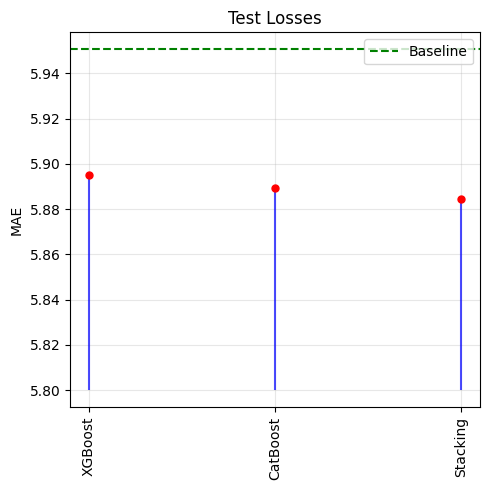

In [171]:
baseline_zero_prediction = 5.950629297205784
stack_mae_test = 5.8843163026543825

models = ['Stacking', 'XGBoost', 'CatBoost']
test_losses = [stack_mae_test, xgb_mae_test, cat_mae_test]
sorted_data = sorted(zip(models, test_losses), key=lambda x: -x[1])
models_sorted, test_losses_sorted = zip(*sorted_data)

plt.figure(figsize=(5, 5))
plt.vlines(range(len(models_sorted)), ymin=5.8, ymax=test_losses_sorted, color='blue',
            alpha=0.7)
plt.plot(range(len(models_sorted)), test_losses_sorted, 'o', color='red', markersize=5)
plt.axhline(y=baseline_zero_prediction, color='green', linestyle='--', label='Baseline')
plt.xticks(range(len(models_sorted)), models_sorted, rotation=90)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.title('Test Losses')
plt.tight_layout()

# Baseline

In [ ]:
train_df = train_df.dropna(subset=['target'])
test_df = test_df.dropna(subset=['target'])

In [97]:
print("Baseline 0 Model results")
baseline_pred = 0.0
train_baseline_mae = (baseline_pred - train_df["target"]).abs().mean()
train_baseline_mse = ((baseline_pred - train_df["target"]) ** 2).mean()
test_baseline_mae = (baseline_pred - test_df["target"]).abs().mean()
test_baseline_mse = ((baseline_pred - test_df["target"]) ** 2).mean()
test_baseline_r2 = r2_score(test_df["target"], [baseline_pred] * len(test_df))


print("Train MAE:", train_baseline_mae)
print("Train MSE:", train_baseline_mse)
print("Test MAE:", test_baseline_mae)
print("Test MSE:", test_baseline_mse)
print("Test R2:", test_baseline_r2)

Baseline 0 Model results
Train MAE: 6.543979047101415
Train MSE: 92.6036655595787
Test MAE: 5.950629297205784
Test MSE: 78.51397289829103
Test R2: -3.668277012991439e-05


In [98]:
simple_mapping = {
                1: 0.1,
                0: 0,
                -1: -0.1}
test_df['baseline_1'] = test_df['imbalance_buy_sell_flag'].map(simple_mapping)
print("Baseline 1 Model results")
test_baseline_mae = mean_absolute_error(test_df["target"], test_df['baseline_1'])
test_baseline_mse = mean_squared_error(test_df["target"], test_df['baseline_1'])
test_baseline_r2 = r2_score(test_df["target"], test_df['baseline_1'])

print("Test MAE:", test_baseline_mae)
print("Test MSE:", test_baseline_mse)
print("Test R2:", test_baseline_r2)

Baseline 1 Model results
Test MAE: 5.951275024542738
Test MSE: 78.52368212155582
Test R2: -0.00016034966746780732


# Results

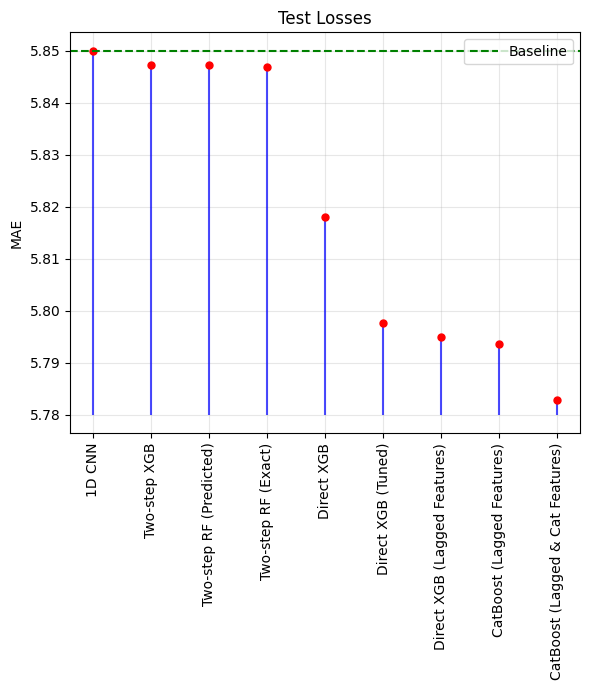

In [55]:
# Test Losses so far
def plot_latest_results(save=False):
  baseline_zero_prediction = 5.8499123043254375
  two_step_index_prediction_rf_wap_exact = 5.846767206098662
  two_step_index_prediction_rf_wap_predicted = 5.8472741657781535
  two_step_index_prediction_xgb = 5.8472744375779
  direct_index_prediction_xgb = 5.8180043931705905
  direct_index_prediction_xgb_tuned = 5.79754806602575
  direct_index_prediction_xgb_tunes_past_features = 5.795017667437385
  cat_boost_past_features = 5.793641841086204
  cat_boost_past_cat_features = 5.782766339896513
  one_d_cnn = 5.850025976086137

  models = ['Two-step RF (Exact)', 'Two-step RF (Predicted)',
            'Two-step XGB', 'Direct XGB', 'Direct XGB (Tuned)', 'Direct XGB (Lagged Features)',
            'CatBoost (Lagged Features)',  'CatBoost (Lagged & Cat Features)', '1D CNN']
  test_losses = [two_step_index_prediction_rf_wap_exact,
                two_step_index_prediction_rf_wap_predicted, two_step_index_prediction_xgb,
                direct_index_prediction_xgb, direct_index_prediction_xgb_tuned,
                direct_index_prediction_xgb_tunes_past_features, cat_boost_past_features,
                cat_boost_past_cat_features, one_d_cnn]

  sorted_data = sorted(zip(models, test_losses), key=lambda x: -x[1])
  models_sorted, test_losses_sorted = zip(*sorted_data)

  plt.figure(figsize=(6, 7))
  plt.vlines(range(len(models_sorted)), ymin=5.78, ymax=test_losses_sorted, color='blue',
            alpha=0.7)
  plt.plot(range(len(models_sorted)), test_losses_sorted, 'o', color='red', markersize=5)
  plt.axhline(y=baseline_zero_prediction, color='green', linestyle='--', label='Baseline')
  plt.xticks(range(len(models_sorted)), models_sorted, rotation=90)
  plt.grid(True, alpha=0.3)
  plt.legend(loc='upper right')
  plt.ylabel('MAE')
  plt.title('Test Losses')
  plt.tight_layout()
  if save:
    plt.savefig("curr_losses.png")
  plt.show()

plot_latest_results(save=True)

In [ ]:
!ls

curr_losses.svg  sample_data
